In [1]:
# Run this cell to set up packages for lecture.
from lec06_imports import *

# Lecture 6, Part 1: Applying

## DSC 10, Summer 2025

### Agenda

- Applying functions to DataFrames.
    - Example: Student names.

***Reminder:*** Use the [DSC 10 Reference Sheet](https://dsc-courses.github.io/bpd-reference/docs/documentation/intro/).

## Quick recap of functions

### Functions are "recipes"

- Functions take in inputs, known as **arguments**, do something, and produce some outputs.
- The beauty of functions is that **you don't need to know how they are implemented in order to use them!**
    - For instance, you've been using the function `bpd.read_csv` without knowing how it works.
    - This is the premise of the idea of **abstraction** in computer science – you'll hear a lot about this if you take DSC 20.

In [2]:
def mystery_func_1(x, y):
    z = x * y
    return z * 3

In [3]:
w = mystery_func_1(2, 3)
print(w)

18


In [4]:
def first_name(full_name):
    '''Returns the first name given a full name.'''
    return full_name.split(' ')[0]

In [5]:
first_name('Evonne Fangao')

'Evonne'

## Applying functions to DataFrames

### DSC 10 student data

The DataFrame `roster` contains the names and lecture sections of all students enrolled in DSC 10 in some previous quarter. The first names are real, while the last names have been anonymized for privacy.

In [6]:
roster = bpd.read_csv('data/roster-anon.csv')
roster

,name,section
0,Cindy Ubobpd,9AM
1,Madeleine Omidge,11AM
2,Caleb Ryincn,11AM
...,...,...
137,Chloe Camvgc,11AM
138,Sophie Ilvrib,11AM
139,Lani Rpcmgt,11AM


### Example: Common first names

What is the most common first name among DSC 10 students? (Any guesses?)

In [7]:
roster

,name,section
0,Cindy Ubobpd,9AM
1,Madeleine Omidge,11AM
2,Caleb Ryincn,11AM
...,...,...
137,Chloe Camvgc,11AM
138,Sophie Ilvrib,11AM
139,Lani Rpcmgt,11AM


- **Problem**: We can't answer that right now, since we don't have a column with first names. If we did, we could group by it.

- **Solution**: Use our function that extracts first names on _every_ element of the `'name'` column.

### Using our `first_name` function

Somehow, we need to call `first_name` on every student's `'name'`.

In [8]:
roster

,name,section
0,Cindy Ubobpd,9AM
1,Madeleine Omidge,11AM
2,Caleb Ryincn,11AM
...,...,...
137,Chloe Camvgc,11AM
138,Sophie Ilvrib,11AM
139,Lani Rpcmgt,11AM


In [9]:
roster.get('name').iloc[0]

'Cindy Ubobpd'

In [10]:
first_name(roster.get('name').iloc[0])

'Cindy'

In [11]:
first_name(roster.get('name').iloc[1])

'Madeleine'

Ideally, there's a better solution than doing this hundreds of times...

### `.apply`

- To **apply** the function `func_name` to every element of column `'col'` in DataFrame `df`, use

<center>
    <code>df.get('col').apply(func_name)</code>
</center>

- The `.apply` method is a **Series** method.
    - **Important**: We use `.apply` on Series, **not** DataFrames.
    - The output of `.apply` is also a Series.

- Pass _just the name_ of the function – don't call it!
    - Good ✅: `.apply(first_name)`.
    - Bad ❌: `.apply(first_name())`.

In [12]:
roster.get('name')

0          Cindy Ubobpd
1      Madeleine Omidge
2          Caleb Ryincn
             ...       
137        Chloe Camvgc
138       Sophie Ilvrib
139         Lani Rpcmgt
Name: name, Length: 140, dtype: object

In [13]:
roster.get('name').apply(first_name)

0          Cindy
1      Madeleine
2          Caleb
         ...    
137        Chloe
138       Sophie
139         Lani
Name: name, Length: 140, dtype: object

### Example: Common first names

In [14]:
roster = roster.assign(
    first=roster.get('name').apply(first_name)
)
roster

,name,section,first
0,Cindy Ubobpd,9AM,Cindy
1,Madeleine Omidge,11AM,Madeleine
2,Caleb Ryincn,11AM,Caleb
...,...,...,...
137,Chloe Camvgc,11AM,Chloe
138,Sophie Ilvrib,11AM,Sophie
139,Lani Rpcmgt,11AM,Lani


In [15]:
roster.groupby('first').count().sort_values(by='name', ascending=False)

,name,section
first,,
Abraham,2,2
Diego,2,2
Audrey,2,2
...,...,...
Diya,1,1
Dante,1,1
Zirong,1,1


Now that we have a column containing first names, we can find the **distribution** of first names.

In [16]:
name_counts = (
    roster
    .groupby('first')
    .count()
    .sort_values('name', ascending=False)
    .get(['name'])
)
name_counts

,name
first,
Abraham,2
Diego,2
Audrey,2
...,...
Diya,1
Dante,1
Zirong,1


### Activity

Below:
- Create a **bar chart** showing the number of students with each first name, but only include first names shared by at least two students.
- Determine the **proportion** of students in DSC 10 who have a first name that is shared by at least two students.

*Hint*: Start by defining a DataFrame with only the names in `name_counts` that appeared at least twice. You can use this DataFrame to answer both questions.

<br>

<details>
<summary>✅ Click <b>here</b> to see the solutions <b>after</b> you've tried it yourself.</summary>
    
<pre>

shared_names = name_counts[name_counts.get('name') >= 2]

# Bar chart.
shared_names.sort_values('name').plot(kind='barh', y='name');

# Proportion = # students with a shared name / total # of students.
shared_names.get('name').sum() / roster.shape[0]

</pre>
    
</details>

In [17]:
name_counts.get("name") > 1

first
Abraham     True
Diego       True
Audrey      True
           ...  
Diya       False
Dante      False
Zirong     False
Name: name, Length: 134, dtype: bool

<Axes: ylabel='first'>

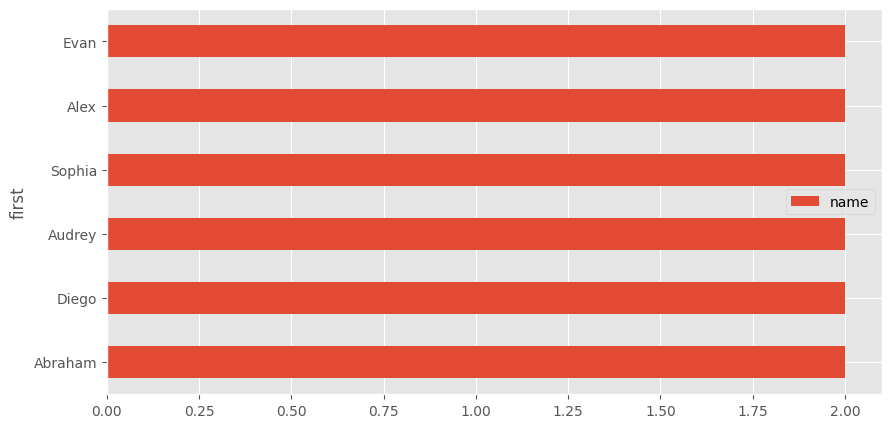

In [18]:
name_counts[name_counts.get("name") > 1].plot(kind='barh')

In [19]:
...

Ellipsis

### `.apply` works with built-in functions, too!

In [20]:
name_counts.get('name')

first
Abraham    2
Diego      2
Audrey     2
          ..
Diya       1
Dante      1
Zirong     1
Name: name, Length: 134, dtype: int64

In [21]:
# Not necessarily meaningful, but doable.
name_counts.get('name').apply(abs)

first
Abraham    2
Diego      2
Audrey     2
          ..
Diya       1
Dante      1
Zirong     1
Name: name, Length: 134, dtype: int64

### Aside: Resetting the index

In `name_counts`, first names are stored in the index, which is **not** a Series. This means we can't use `.apply` on it.

In [22]:
name_counts

,name
first,
Abraham,2
Diego,2
Audrey,2
...,...
Diya,1
Dante,1
Zirong,1


In [23]:
name_counts.index

Index(['Abraham', 'Diego', 'Audrey', 'Sophia', 'Alex', 'Evan', 'Aaron', 'Nhan',
       'Nancy', 'Natalie',
       ...
       'Giang', 'Georgia', 'Ganya', 'Ethan', 'Enoch', 'Emma', 'Elizabeth',
       'Diya', 'Dante', 'Zirong'],
      dtype='object', name='first', length=134)

In [24]:
name_counts.index.apply(max)

AttributeError: 'Index' object has no attribute 'apply'

In [25]:
name_counts.reset_index()

,first,name
0,Abraham,2
1,Diego,2
2,Audrey,2
...,...,...
131,Diya,1
132,Dante,1
133,Zirong,1


To help, we can use `.reset_index()` to turn the index of a DataFrame into a column, and to reset the index back to the default of 0, 1, 2, 3, and so on.

In [26]:
# What is the max of an individual string?
name_counts.reset_index().get('first').apply(max)

0      r
1      o
2      y
      ..
131    y
132    t
133    r
Name: first, Length: 134, dtype: object

In [27]:
def first_char(in_str):
    lol_str = in_str[0]
    return lol_str

In [28]:
first_char('Aedan')

'A'

In [29]:
name_counts.reset_index().get('first').apply(first_char)

0      A
1      D
2      A
      ..
131    D
132    D
133    Z
Name: first, Length: 134, dtype: object

### Example: Shared first names and sections

- Suppose you're one of the students who has a first name that is shared with at least one other student.
- Let's try and determine whether someone **in your lecture section** shares the same first name as you.
    - For example, maybe `'Evan Flmeik'` wants to see if there's another `'Evan'` in their section. 

Strategy:
1. Which section is `'Evan Flmeik'` in?
2. How many people in that section have a first name of `'Evan'`?

In [30]:
roster

,name,section,first
0,Cindy Ubobpd,9AM,Cindy
1,Madeleine Omidge,11AM,Madeleine
2,Caleb Ryincn,11AM,Caleb
...,...,...,...
137,Chloe Camvgc,11AM,Chloe
138,Sophie Ilvrib,11AM,Sophie
139,Lani Rpcmgt,11AM,Lani


In [31]:
which_section = roster[roster.get('name') == 'Evan Flmeik'].get('section').iloc[0]
which_section

'9AM'

In [32]:
first_cond = roster.get('first') == 'Evan' # A Boolean Series!
section_cond = roster.get('section') == which_section # A Boolean Series!
how_many = roster[first_cond & section_cond].shape[0]
how_many

1

### Another function: `shared_first_and_section`

Let's create a function named `shared_first_and_section`. It will take in the **full name** of a student and return **the number** of students in their section with the same first name and section (including them).

*Note*: This is the first function we're writing that involves using a DataFrame within the function – this is fine!

In [33]:
def shared_first_and_section(name):
    # First, find the row corresponding to that full name in roster.
    # We're assuming that full names are unique.
    row = roster[roster.get('name') == name]
    
    # Then, get that student's first name and section.
    first = row.get('first').iloc[0]
    section = row.get('section').iloc[0]
    
    # Now, find all the students with the same first name and section.
    shared_info = roster[(roster.get('first') == first) & (roster.get('section') == section)]
    
    # Return the number of such students.
    return shared_info.shape[0]

In [34]:
shared_first_and_section('Evan Flmeik')

1

Now, let's add a column to `roster` that contains the values returned by `shared_first_and_section`.

In [35]:
roster = roster.assign(shared=roster.get('name').apply(shared_first_and_section))
roster

,name,section,first,shared
0,Cindy Ubobpd,9AM,Cindy,1
1,Madeleine Omidge,11AM,Madeleine,1
2,Caleb Ryincn,11AM,Caleb,1
...,...,...,...,...
137,Chloe Camvgc,11AM,Chloe,1
138,Sophie Ilvrib,11AM,Sophie,1
139,Lani Rpcmgt,11AM,Lani,1


Let's find all of the students who are in a section with someone that has the same first name as them.

In [36]:
roster[(roster.get('shared') >= 2)].sort_values('shared', ascending=False)

,name,section,first,shared
75,Audrey Vmoxvk,11AM,Audrey,2
84,Alex Ihhwal,9AM,Alex,2
95,Audrey Deofem,11AM,Audrey,2
113,Alex Dxnfiv,9AM,Alex,2


### Activity

Find the longest first name in the class that is shared by at least two students in the same section.

*Hint*: You'll have to use both `.assign` and `.apply`.

<br>

<details>
<summary>✅ Click <b>here</b> to see the answer <b>after</b> you've tried it yourself.</summary>
    
<pre>

with_len = roster.assign(name_len=roster.get('first').apply(len))
with_len[with_len.get('shared') >= 2].sort_values('name_len', ascending=False).get('first').iloc[0]

</pre>
    
</details>

In [37]:
...

Ellipsis